In [3]:
import pandas as pd

# Load the two CSV files from data folder
accident_location = pd.read_csv(r"C:\Users\Suman\Downloads\R2B2\data\accident_location.csv")
accident = pd.read_csv(r"C:\Users\Suman\Downloads\R2B2\data\accident.csv")

# Merge the two tables on accident id (ACCIDENT_NO)
merged_df = accident.merge(accident_location, on="ACCIDENT_NO", how="inner")

# Filter for only the required locations
locations_filter = ["Baw Baw", "Stirling", "Hotham", "Buller", "Falls Creek"]
filtered_df = merged_df[
    merged_df["ROAD_NAME"].str.contains('|'.join(locations_filter), case=False, na=False)
]

# Show first few rows
print(filtered_df.head())

# Save to CSV in the same data folder
filtered_df.to_csv(r"C:\Users\Suman\Downloads\R2B2\data\filtered_accidents.csv", index=False)


       ACCIDENT_NO ACCIDENT_DATE ACCIDENT_TIME  ACCIDENT_TYPE  \
787   T20140000971    2014-01-16      07:49:00              1   
1818  T20230003009    2023-02-02      19:00:00              1   
3208  T20130025727    2013-12-13      22:50:00              1   
3496  T20200018147    2020-10-12      20:00:00              4   
4005  T20180014240    2018-07-29      14:50:00              6   

                     ACCIDENT_TYPE_DESC  DAY_OF_WEEK DAY_WEEK_DESC  DCA_CODE  \
787              Collision with vehicle            5      Thursday       160   
1818             Collision with vehicle            4      Thursday       130   
3208             Collision with vehicle            6        Friday       110   
3496      Collision with a fixed object            2        Monday       183   
4005  Vehicle overturned (no collision)            1        Sunday       170   

                                               DCA_DESC  LIGHT_CONDITION  ...  \
787   VEHICLE COLLIDES WITH VEHICLE PARKED ON L

C:\Users\Suman\AppData\Local\Temp\ipykernel_32684\3487432148.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Hour"] = pd.to_datetime(df["ACCIDENT_TIME"], errors="coerce").dt.hour
C:\Users\Suman\AppData\Local\Temp\ipykernel_32684\3487432148.py:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[name.str.contains(pat, na=False, regex=True), "Location"] = canon
C:\Users\Suman\AppData\Local\Temp\ipykernel_32684\3487432148.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mount Buller' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[name.str.contains(pat, na=False, regex=True), "Location"] = canon
C:\Users\Suman\AppDat

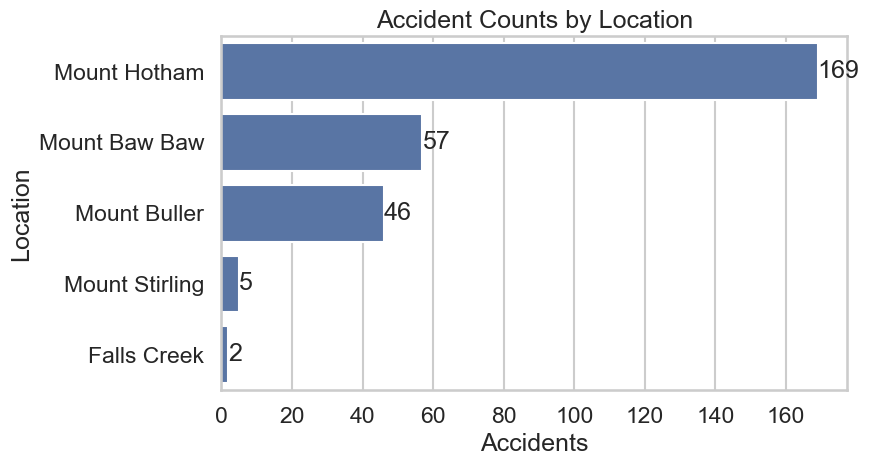

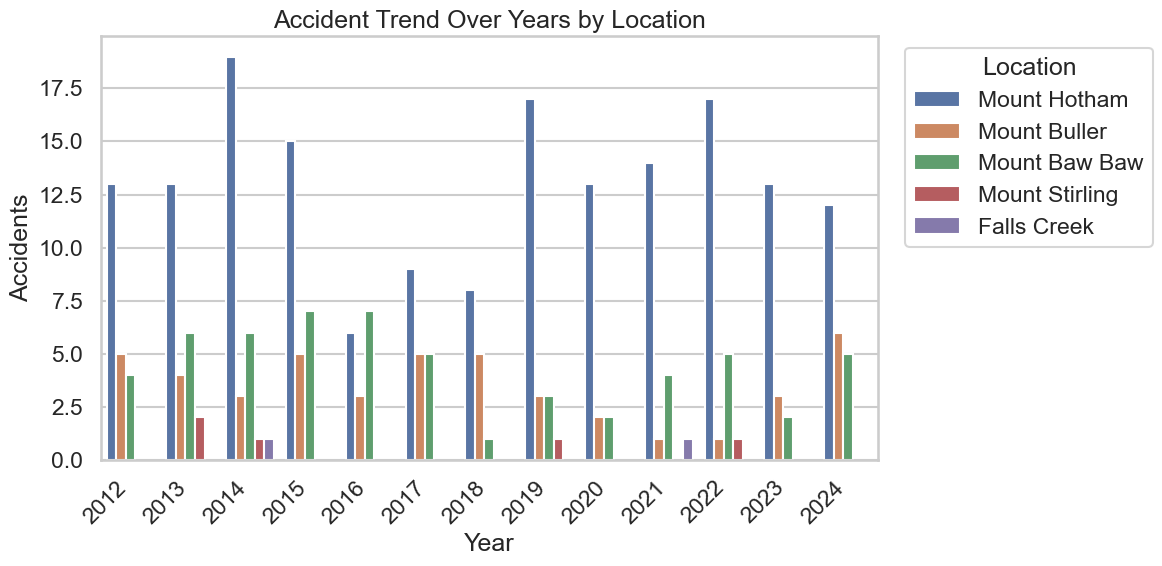

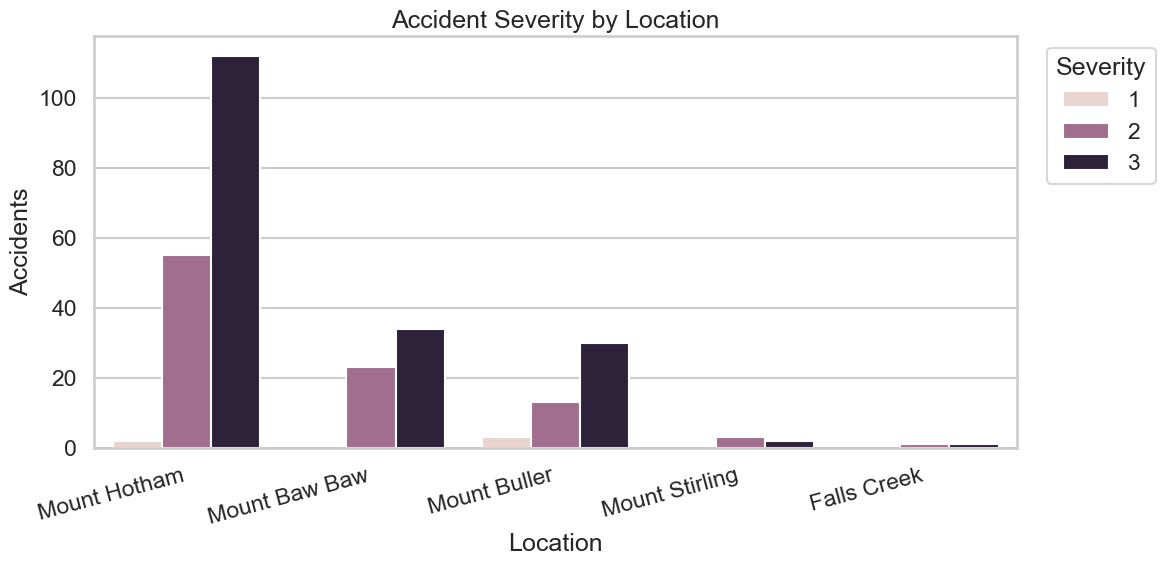

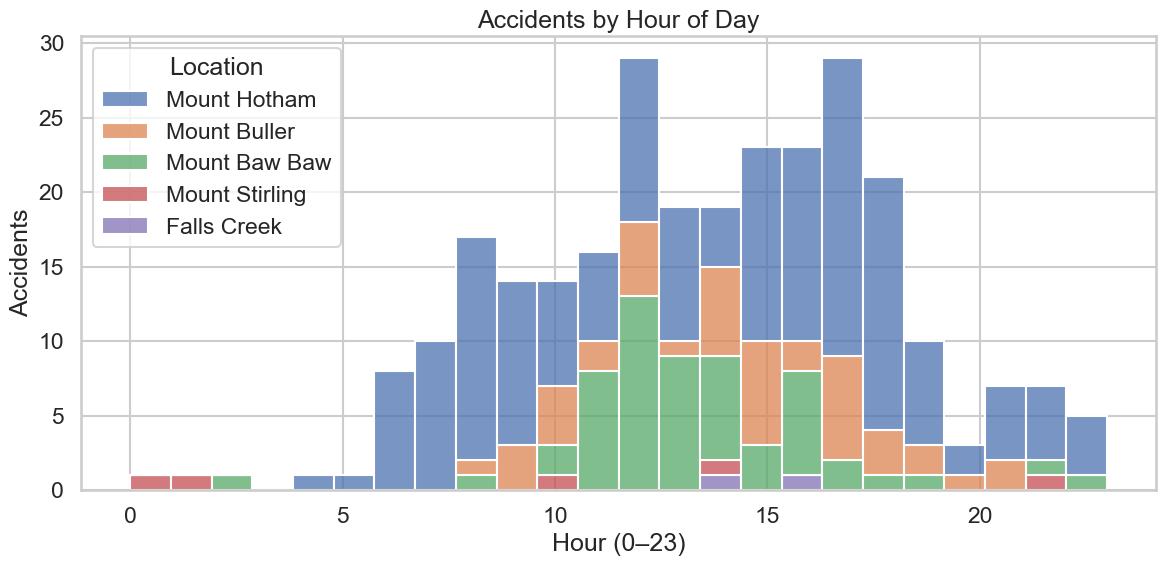

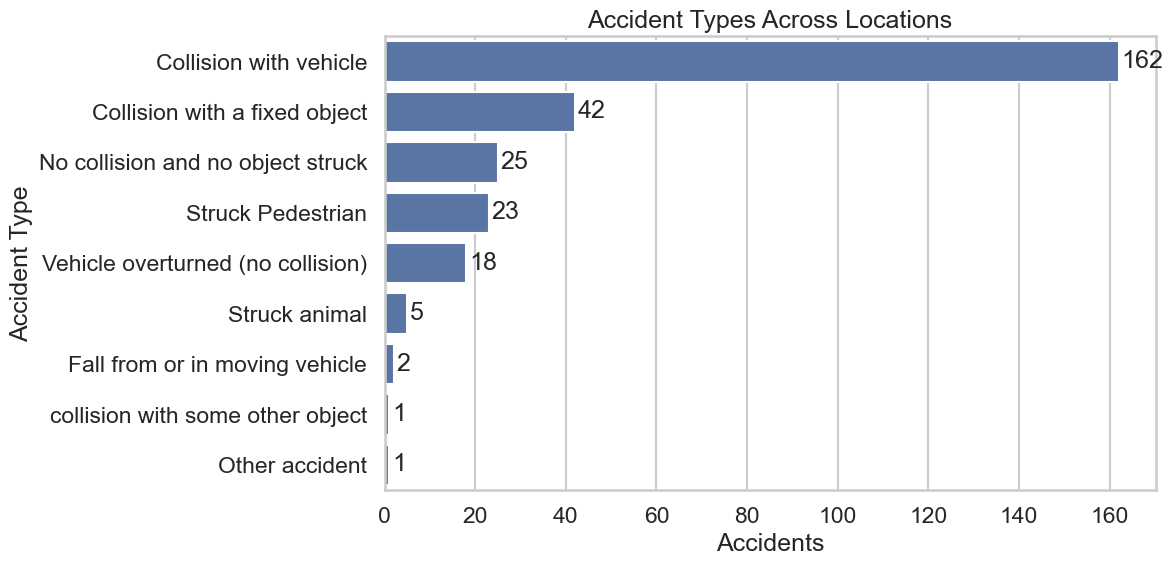

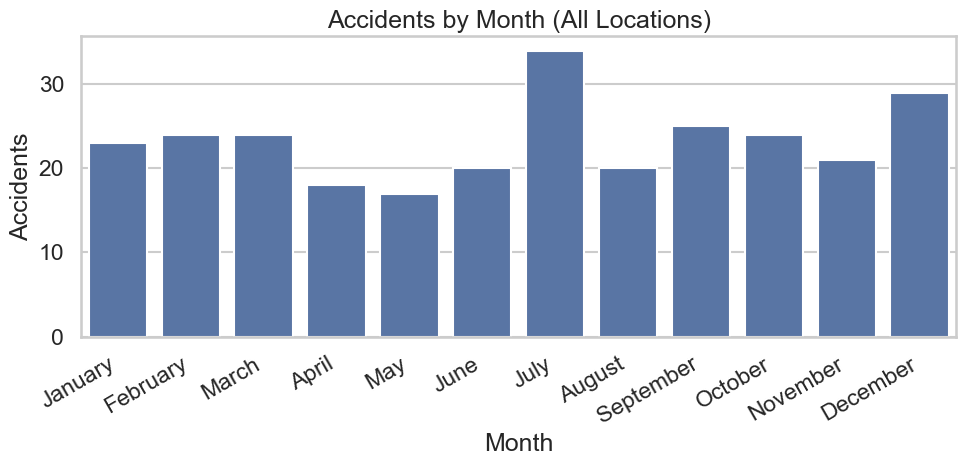

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load once
df = pd.read_csv(r"C:\Users\Suman\Downloads\R2B2\data\filtered_accidents.csv")

# Parse dates + handy time columns
df["ACCIDENT_DATE"] = pd.to_datetime(df["ACCIDENT_DATE"], errors="coerce")
df = df.dropna(subset=["ACCIDENT_DATE"]).copy()
df["Year"]      = df["ACCIDENT_DATE"].dt.year
df["Month"]     = df["ACCIDENT_DATE"].dt.month
df["MonthName"] = pd.Categorical(
    df["ACCIDENT_DATE"].dt.month_name(),
    categories=["January","February","March","April","May","June",
                "July","August","September","October","November","December"],
    ordered=True
)
df["Week"] = df["ACCIDENT_DATE"].dt.isocalendar().week.astype(int)
df["Hour"] = pd.to_datetime(df["ACCIDENT_TIME"], errors="coerce").dt.hour

# ---- unify location names into a single 'Location' column ----
name = df["ROAD_NAME"].astype(str).str.lower()

patterns = {
    "Mount Buller":   r"\b(buller|mt\s*buller|mount\s*buller)\b",
    "Mount Baw Baw":  r"\b(baw\s*baw|mt\s*baw\s*baw|mount\s*baw\s*baw)\b",
    "Mount Hotham":   r"\b(hotham|mt\s*hotham|mount\s*hotham)\b",
    "Falls Creek":    r"\b(falls\s*creek)\b",
    "Mount Stirling": r"\b(stirling|mt\s*stirling|mount\s*stirling)\b",
}

df["Location"] = np.nan
for canon, pat in patterns.items():
    df.loc[name.str.contains(pat, na=False, regex=True), "Location"] = canon

# keep only our five resorts
df = df[df["Location"].notna()].copy()

# nice global look
sns.set_theme(style="whitegrid", context="talk")

# helper: order locations by frequency
loc_order = df["Location"].value_counts().index

# 1) Accident counts by location
plt.figure(figsize=(9,5))
ax = sns.countplot(y="Location", data=df, order=loc_order)
ax.bar_label(ax.containers[0])
plt.title("Accident Counts by Location")
plt.xlabel("Accidents"); plt.ylabel("Location")
plt.tight_layout(); plt.show()

# 2) Accidents over years (by location)
plt.figure(figsize=(12,6))
sns.countplot(x="Year", data=df, hue="Location")
plt.title("Accident Trend Over Years by Location")
plt.xlabel("Year"); plt.ylabel("Accidents")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Location", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

# 3) Severity by location
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="Location", hue="SEVERITY", order=loc_order)
plt.title("Accident Severity by Location")
plt.xlabel("Location"); plt.ylabel("Accidents")
plt.xticks(rotation=15, ha="right")
plt.legend(title="Severity", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

# 4) Accidents by hour of day
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="Hour", hue="Location", multiple="stack", bins=24, edgecolor=None)
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour (0–23)"); plt.ylabel("Accidents")
plt.tight_layout(); plt.show()

# 5) Accident types overall
plt.figure(figsize=(12,6))
order_types = df["ACCIDENT_TYPE_DESC"].value_counts().index
ax = sns.countplot(data=df, y="ACCIDENT_TYPE_DESC", order=order_types)
for c in ax.containers:
    ax.bar_label(c, padding=2)
plt.title("Accident Types Across Locations")
plt.xlabel("Accidents"); plt.ylabel("Accident Type")
plt.tight_layout(); plt.show()

# 6) Accidents by month (overall)
plt.figure(figsize=(10,5))
sns.countplot(x="MonthName", data=df)
plt.title("Accidents by Month (All Locations)")
plt.xlabel("Month"); plt.ylabel("Accidents")
plt.xticks(rotation=30, ha="right")
plt.tight_layout(); plt.show()


C:\Users\Suman\AppData\Local\Temp\ipykernel_32684\423668050.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[name.str.contains(pat, case=False, na=False, regex=True), "Location"] = canon
C:\Users\Suman\AppData\Local\Temp\ipykernel_32684\423668050.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mount Buller' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[name.str.contains(pat, case=False, na=False, regex=True), "Location"] = canon
C:\Users\Suman\AppData\Local\Temp\ipykernel_32684\423668050.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[name.str.contains(pat, case=False, na=False, regex=True), "Location"] = canon
C:\Users\Suman\AppData\Local\Temp\ipyker

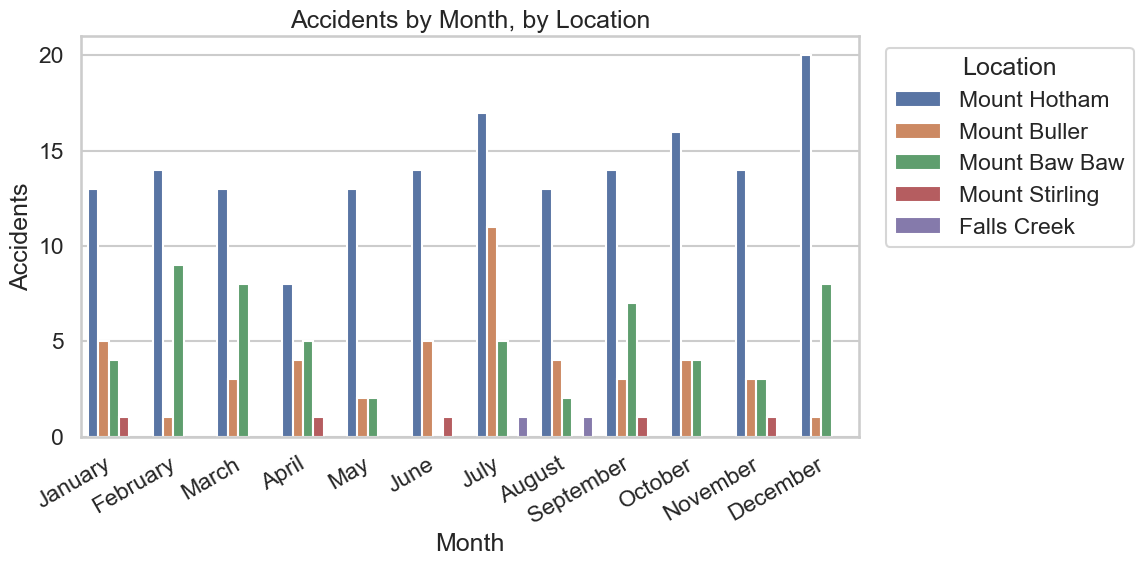

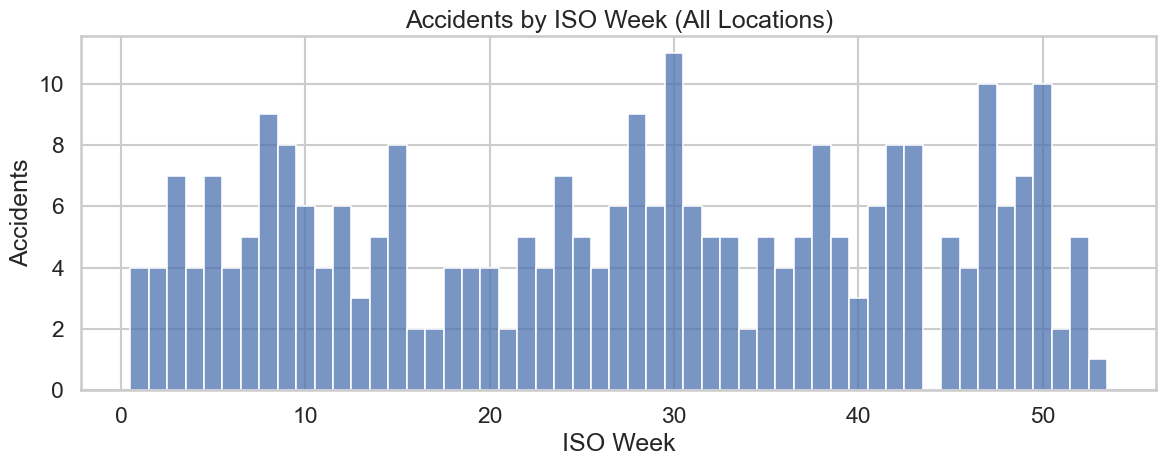

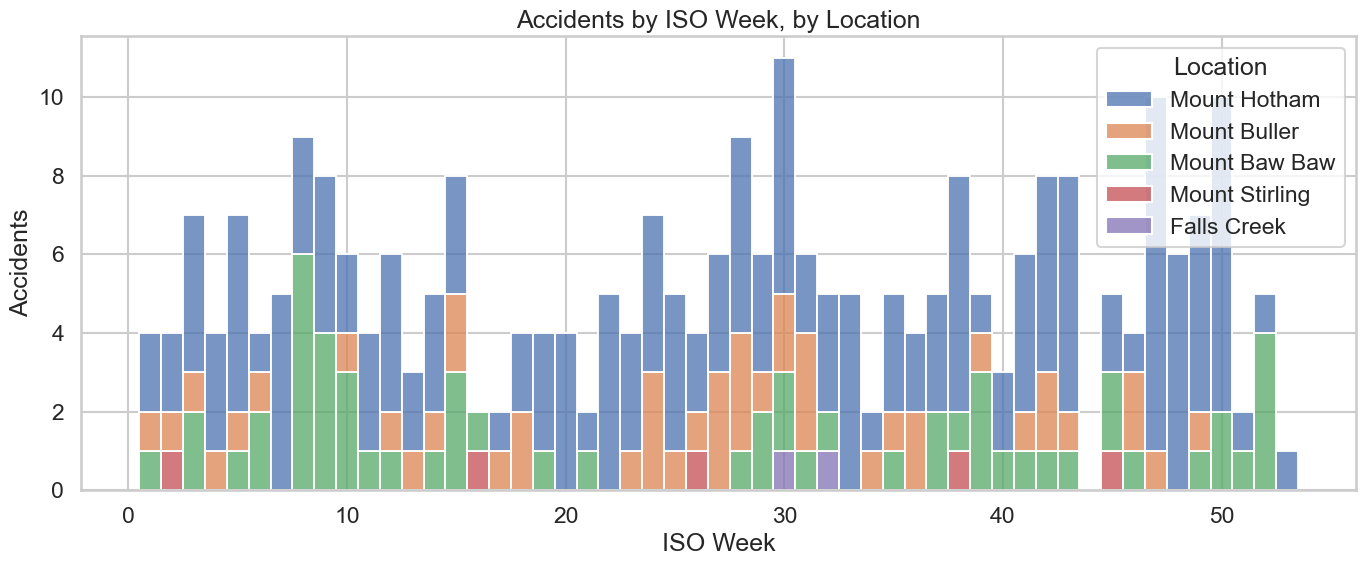

Peak month overall: July (#7)
Peak ISO week overall: 30

Top 5 months:
 MonthName
July         34
December     29
September    25
February     24
March        24
Name: count, dtype: int64

Top 5 ISO weeks:
 Week
30    11
50    10
47    10
28     9
8      9
Name: count, dtype: int64


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# unify ROAD_NAME variants -> Location
name = df["ROAD_NAME"].astype(str).str.lower()
patterns = {
    "Mount Buller":   r"\b(buller|mt\s*buller|mount\s*buller)\b",
    "Mount Baw Baw":  r"\b(baw\s*baw|mt\s*baw\s*baw|mount\s*baw\s*baw)\b",
    "Mount Hotham":   r"\b(hotham|mt\s*hotham|mount\s*hotham)\b",
    "Falls Creek":    r"\b(falls\s*creek)\b",
    "Mount Stirling": r"\b(stirling|mt\s*stirling|mount\s*stirling)\b",
}
df["Location"] = np.nan
for canon, pat in patterns.items():
    df.loc[name.str.contains(pat, case=False, na=False, regex=True), "Location"] = canon
df = df[df["Location"].notna()].copy()

# make sure Month/MonthName/Week exist and are ordered nicely
df["ACCIDENT_DATE"] = pd.to_datetime(df["ACCIDENT_DATE"], errors="coerce")
df = df.dropna(subset=["ACCIDENT_DATE"])
df["Month"] = df["ACCIDENT_DATE"].dt.month
df["MonthName"] = pd.Categorical(
    df["ACCIDENT_DATE"].dt.month_name(),
    categories=["January","February","March","April","May","June",
                "July","August","September","October","November","December"],
    ordered=True
)
df["Week"] = df["ACCIDENT_DATE"].dt.isocalendar().week.astype(int)

sns.set_theme(style="whitegrid", context="talk")

# 7) Accidents by month (split by unified Location)
plt.figure(figsize=(12,6))
sns.countplot(x="MonthName", data=df, hue="Location")
plt.title("Accidents by Month, by Location")
plt.xlabel("Month"); plt.ylabel("Accidents")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Location", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

# 8) Accidents by ISO week (overall)
plt.figure(figsize=(12,5))
sns.histplot(df["Week"], bins=range(1,54), discrete=True, edgecolor=None)
plt.title("Accidents by ISO Week (All Locations)")
plt.xlabel("ISO Week"); plt.ylabel("Accidents")
plt.tight_layout(); plt.show()

# 9) Accidents by ISO week (split by unified Location)
plt.figure(figsize=(14,6))
sns.histplot(data=df, x="Week", hue="Location",
             bins=range(1,54), multiple="stack", discrete=True, edgecolor=None)
plt.title("Accidents by ISO Week, by Location")
plt.xlabel("ISO Week"); plt.ylabel("Accidents")
plt.tight_layout(); plt.show()

# quick summary for slides
peak_month_num  = int(df["Month"].mode().iloc[0])
peak_month_name = df["MonthName"].mode().iloc[0]
peak_week       = int(df["Week"].mode().iloc[0])
print(f"Peak month overall: {peak_month_name} (#{peak_month_num})")
print(f"Peak ISO week overall: {peak_week}")
print("\nTop 5 months:\n", df["MonthName"].value_counts().head(5))
print("\nTop 5 ISO weeks:\n", df["Week"].value_counts().head(5))

C:\Users\Suman\AppData\Local\Temp\ipykernel_32684\748018397.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[name.str.contains(pat, case=False, na=False), "Location"] = canon
C:\Users\Suman\AppData\Local\Temp\ipykernel_32684\748018397.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mount Buller' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[name.str.contains(pat, case=False, na=False), "Location"] = canon
C:\Users\Suman\AppData\Local\Temp\ipykernel_32684\748018397.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[name.str.contains(pat, case=False, na=False), "Location"] = canon
C:\Users\Suman\AppData\Local\Temp\ipykernel_32684\748018397.py:15: UserWarni

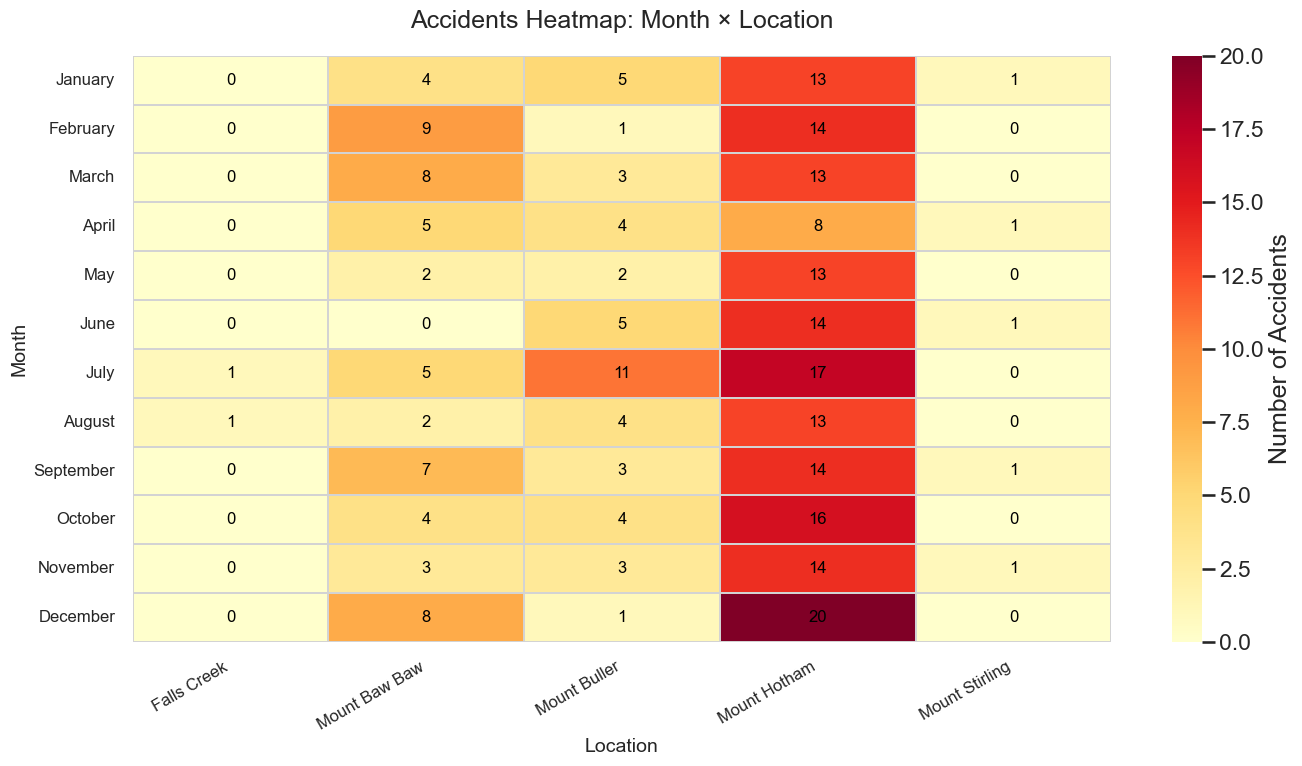

In [16]:
#10) Heatmap
# Clean + unify location names
name = df["ROAD_NAME"].astype(str).str.lower()

patterns = {
    "Mount Buller":   r"\b(buller|mt\s*buller|mount\s*buller)\b",
    "Mount Baw Baw":  r"\b(baw\s*baw|mt\s*baw\s*baw|mount\s*baw\s*baw)\b",
    "Mount Hotham":   r"\b(hotham|mt\s*hotham|mount\s*hotham)\b",
    "Falls Creek":    r"\b(falls\s*creek)\b",
    "Mount Stirling": r"\b(stirling|mt\s*stirling|mount\s*stirling)\b",
}

df["Location"] = np.nan
for canon, pat in patterns.items():
    df.loc[name.str.contains(pat, case=False, na=False), "Location"] = canon

# Drop rows that don’t match our five resorts
df = df[df["Location"].notna()].copy()

# Ensure month order is correct
df["ACCIDENT_DATE"] = pd.to_datetime(df["ACCIDENT_DATE"], errors="coerce")
df = df.dropna(subset=["ACCIDENT_DATE"])
df["MonthName"] = pd.Categorical(
    df["ACCIDENT_DATE"].dt.month_name(),
    categories=["January","February","March","April","May","June",
                "July","August","September","October","November","December"],
    ordered=True
)

# Build pivot with cleaned Location
month_loc = (
    df.groupby(["MonthName", "Location"])["ACCIDENT_NO"]
      .count().reset_index(name="count")
      .pivot(index="MonthName", columns="Location", values="count")
      .fillna(0).astype(int)
)

plt.figure(figsize=(14,8))
sns.heatmap(
    month_loc,
    annot=True,
    fmt="d",
    cmap="YlOrRd",
    linewidths=.3,
    linecolor="lightgrey",
    cbar_kws={'label': 'Number of Accidents'},
    annot_kws={"size":12, "color":"black"}
)
plt.title("Accidents Heatmap: Month × Location", fontsize=18, pad=20)
plt.xlabel("Location", fontsize=14)
plt.ylabel("Month", fontsize=14)
plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\Suman\AppData\Local\Temp\ipykernel_32684\2628899741.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["MonthName", "Location"])["ACCIDENT_NO"]


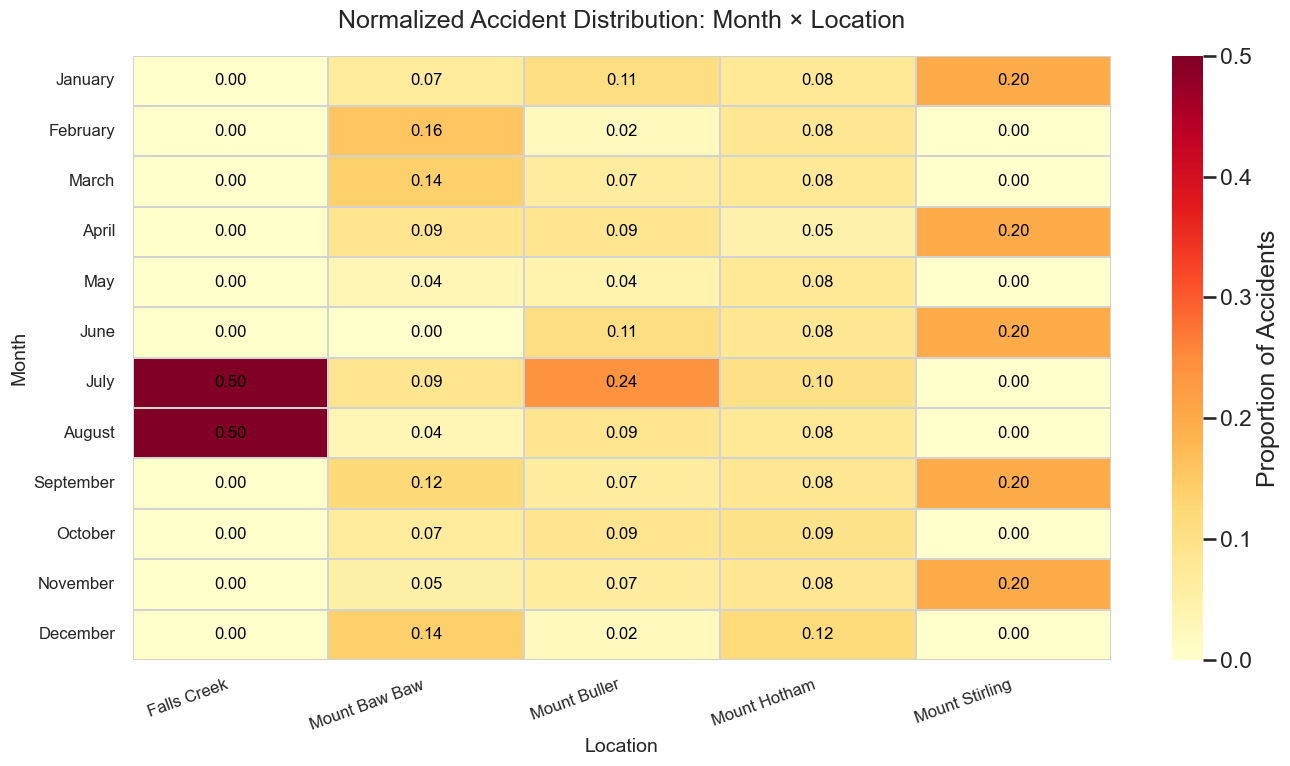

In [19]:

# Ensure MonthName is ordered nicely
df["ACCIDENT_DATE"] = pd.to_datetime(df["ACCIDENT_DATE"], errors="coerce")
df = df.dropna(subset=["ACCIDENT_DATE"])
df["MonthName"] = pd.Categorical(
    df["ACCIDENT_DATE"].dt.month_name(),
    categories=["January","February","March","April","May","June",
                "July","August","September","October","November","December"],
    ordered=True
)

#  Pivot (counts) then normalize per location (column-wise) 
month_loc = (
    df.groupby(["MonthName", "Location"])["ACCIDENT_NO"]
      .count().reset_index(name="count")
      .pivot(index="MonthName", columns="Location", values="count")
      .fillna(0).astype(int)
)

# Column-normalize so each location sums to 1.0
month_loc_norm = month_loc.div(month_loc.sum(axis=0).replace(0, np.nan), axis=1)

# --- Pretty heatmap ---
plt.figure(figsize=(14,8))
sns.heatmap(
    month_loc_norm,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    linewidths=.3,
    linecolor="lightgrey",
    cbar_kws={'label': 'Proportion of Accidents'},
    annot_kws={"size":12, "color":"black"}
)
plt.title("Normalized Accident Distribution: Month × Location", fontsize=18, pad=20)
plt.xlabel("Location", fontsize=14)
plt.ylabel("Month", fontsize=14)
plt.xticks(rotation=20, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()
